In [1]:
# activiate inline plotting
%pylab inline
# load modules
import sys
import scipy as SP
import pylab as PL
from matplotlib import cm
import h5py
import os
import GPy
import numpy as np
import pandas as pd

#adjust path
scLVM_BASE = '/Users/jiwang/anaconda3/envs/scLVM/lib/python2.7/site-packages/'
from scLVM import scLVM

sys.path.append('/Users/jiwang/anaconda3/envs/scLVM/')
#sys.path.append( scLVM_BASE +'..')
sys.path.append(scLVM_BASE + 'scLVM/utils') #this is not included in the github repo
#sys.path.append(scLVM_BASE +'CFG')
#from misc import *
#from barplot import *
#from default import *
#from scLVM.utils.barplot import *
#from scLVM.utils.misc import *

from IPython.display import Latex

Populating the interactive namespace from numpy and matplotlib


In [2]:
help(scLVM.fitGPLVM)

Help on method fitGPLVM in module scLVM.core:

fitGPLVM(self, idx=None, k=1, standardize=False, out_dir='./cache', file_name=None, recalc=False, use_ard=False, save_K=True) unbound scLVM.core.scLVM method
    Args:
            idx:                    index of the genes involved
                                            (e.g., for capturing cell cycle, index of cell cycle genes)
            k:                              number of latent factors
            standardize:    if True, rescale gene expression by std prior to fitting GPLVM
                                            (data are always mean-centered)
            out_dir:                dir used to cache the results
            file_name:              if not None, caches the results in the out_dir if the file does not exist
                                            if the file exists loads the results if recalc is True
            recalc:                 if True and cache file exists, rewrite cacheFile
            use_ard: 

In [3]:
Y = pd.read_csv("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/gene_expression_matrx_4scLVM.txt", sep='\t', header = None)                  # gene expression matrix
idx_cell_cycle = pd.read_csv("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/index_ccgenes_4scLVM.txt", sep='\t', header = None)

tech_noise = pd.read_csv("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/tech_noise_4scLVM.txt", sep='\t')
genesID = pd.read_csv("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/geneNames_4scLVM.txt", sep='\t')
genes_het_bool = pd.read_csv("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/index_hetgenes_4scLVM.txt",sep='\t')

Y = Y.as_matrix()
#tech_noise = tech_noise

#genes_het_bool = genes_het_bool
#tech_noise = f['LogVar_techMmus'][:]       # technical noise
#genes_het_bool=f['genes_heterogen'][:]     # index of heterogeneous genes
#geneID = f['gene_names'][:]            # gene names
#cellcyclegenes_filter = SP.unique(f['cellcyclegenes_filter'][:].ravel() -1) # idx of cell cycle genes from GO
#cellcyclegenes_filterCB = f['ccCBall_gene_indices'][:].ravel() -1        # idx of cell cycle genes from cycle base ...

 /Users/jiwang/anaconda3/envs/scLVM/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning:Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
#help(scLVM)

In [5]:
# filter cell cycle genes
#idx_cell_cycle = SP.union1d(cellcyclegenes_filter,cellcyclegenes_filterCB)
# determine non-zero counts
idx_nonzero = SP.nonzero((Y.mean(0)**2)>0)[0]
idx_cell_cycle_noise_filtered = SP.intersect1d(idx_cell_cycle,idx_nonzero)
# subset gene expression matrix
Ycc = Y[:,idx_cell_cycle_noise_filtered]

Text(0,0.5,'cells')

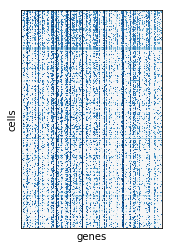

In [6]:
plt = PL.subplot(1,1,1)
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
#PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('genes')
PL.ylabel('cells')

In [7]:
k = 80                    # number of latent factors
out_dir = '/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/cache_scLVM'       # folder where results are cached
file_name = 'Kcc.hdf5'    # name of the cache file
recalc = True             # recalculate X and Kconf
use_ard = True            # use automatic relevance detection
sclvm = scLVM(Y)
#Fit model with 80 factors
X_ARD,Kcc_ARD,varGPLVM_ARD = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=k,out_dir=out_dir,file_name=file_name,recalc=recalc, use_ard=use_ard)


Text(0,0.5,'Variance explained')

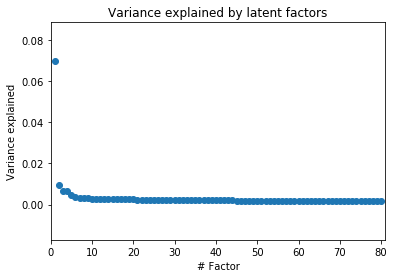

In [8]:
#Plot variance contributions from ARD 
plt = PL.subplot(1,1,1)
PL.title('Variance explained by latent factors')
PL.scatter(SP.arange(k)+1,varGPLVM_ARD['X_ARD'])
PL.xlim([0,k+1])
PL.xlabel('# Factor')
PL.ylabel('Variance explained')

In [9]:
#Fit model with a single factor (rank 1 covariance matrix)
X,Kcc,varGPLVM = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=1,out_dir=out_dir,file_name=file_name,recalc=True, use_ard=False)

Text(0,0.5,'cells')

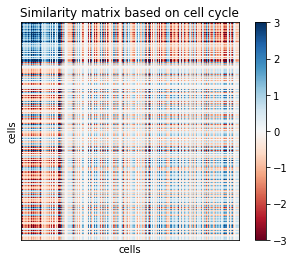

In [10]:
#Plot inferred similarity matrix
plt = PL.subplot(1,1,1)
PL.title('Similarity matrix based on cell cycle')
PL.imshow(Kcc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('cells')
PL.ylabel('cells')

In [11]:
#genes_het_bool==1
genes_het_bool.head()
#Y.shape
#Ihet.shape
#Ihet
#Y_Ihet    = Y[:,Ihet]
tech_noise["x"][genes_het_bool['x']].head()
#xx = (tech_noise[:,0])
#xx

3     0.226552
5     0.046385
8     0.521485
9     0.061717
18    0.716184
Name: x, dtype: float64

In [12]:
# considers only heterogeneous genes
Ihet = genes_het_bool['x']

Y    = Y[:,Ihet]
tech = tech_noise['x'][Ihet]
genesID = genesID['x'][Ihet]
#Y_Ihet.shape()
#Ihet.head()
genesID_Ihet.head()

3     aat-9
5     abt-5
8     aco-2
9     acr-7
18    act-3
Name: x, dtype: object

In [18]:
help(sclvm.varianceDecomposition)
Y_Ihet.shape

Help on method varianceDecomposition in module scLVM.core:

varianceDecomposition(self, K=None, tech_noise=None, idx=None, i0=None, i1=None, max_iter=10, verbose=False) method of scLVM.core.scLVM instance
    Args:
            K:                              list of random effects to be considered in the analysis
            idx:                    indices of the genes to be considered in the analysis
            i0:                             gene index from which the anlysis starts
            i1:                             gene index to which the analysis stops
            max_iter:               maximum number of random restarts
            verbose:                if True, print progresses



(895, 2877)

In [19]:
#optionally: restrict range for the analysis
i0 = 0    # gene from which the analysis starts
i1 = 2000 # gene at which the analysis ends 

# construct sclvm object
sclvm = scLVM(Y_Ihet,geneID=genesID_Ihet,tech_noise=tech_noise_Ihet)

# fit the model from i0 to i1
sclvm.varianceDecomposition(K=Kcc, i0=i0,i1=i1)

KeyError: 0

In [16]:
normalize=True    # variance components are normalizaed to sum up to one

# get variance components
var, var_info = sclvm.getVarianceComponents(normalize=normalize)
var_filtered = var[var_info['conv']] # filter out genes for which vd has not converged

# get corrected expression levels
Ycorr = sclvm.getCorrectedExpression()
Ycorr.shape

AssertionError: scLVM:: use varianceDecomposition method before

In [ ]:
#calculate average variance components across all genes and visualize
var_mean = var_filtered.mean(0)
colors = ['Green','MediumBlue','Gray']
pp=PL.pie(var_mean,labels=var_info['col_header'],autopct='%1.1f%%',colors=colors,
       shadow=True, startangle=0)

In [ ]:
H2=1-var_filtered[:,2]
var_comp_fileds = SP.array([[0, 'cell cycle', 'Peru'],
       [1, 'biol. var', 'DarkMagenta'],
       [2, 'tech. var', '#92c5de']], dtype=object)
var_plot(var_filtered,H2,var_comp_fileds,normalize=True, figsize=[5,4])

In [ ]:
i0 = 0     # gene from which the analysis starts
i1 = 10    # gene to which the analysis ends

# fit lmm without correction
pv0,beta0,info0 = sclvm.fitLMM(K=None,i0=i0,i1=i1,verbose=False)
# fit lmm with correction
pv1,beta1,info1 = sclvm.fitLMM(K=Kcc,i0=i0,i1=i1,verbose=False)

In [ ]:
plt=PL.subplot(2,2,1)
PL.title('Without Correction')
p=PL.imshow(beta0[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')
plt=PL.subplot(2,2,2)
PL.title('With Correction')
p=PL.imshow(beta1[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')

In [ ]:
SP.savetxt('Ycorr.txt',Ycorr)

In [ ]:
# Model optimization
Ystd = Ycorr-Ycorr.mean(0)
Ystd/=Ystd.std(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=0, max_iters=2000)


In [ ]:
m.kern.plot_ARD()

In [ ]:
i_Gata3 = SP.where(geneID=='ENSMUSG00000015619')
color = Ycorr[:,i_Gata3]
#color = Ycorr[:,0]
PL.scatter(m.X[:,0]['mean'], m.X[:,1]['mean'], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

In [ ]:
[S,W] = PCA(Ystd,2)

In [ ]:
PL.scatter(S[:,0],S[:,1], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()